# Workplace

## Data Preprocessing

### Imputation below:

1. Filled all error data and missing data with `random data from 10 to 99`.
2. Adjust age less than 10 and greater than 99.
    - Handled the data with semantic error

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import preprocess as pre

Handle and analyse the raw data
Put percentage of ages into a dictionary, use the values of the dictionary as the weight of random

In [41]:
users_file = "BX-Users.csv"
books_file = "BX-Books.csv"
rating_file = "BX-Ratings.csv"
new_users_file = "BX-NewBooksUsers.csv"
new_books_file = "BX-NewBooks.csv"
new_ratings_file = "BX-NewBooksRatings.csv"

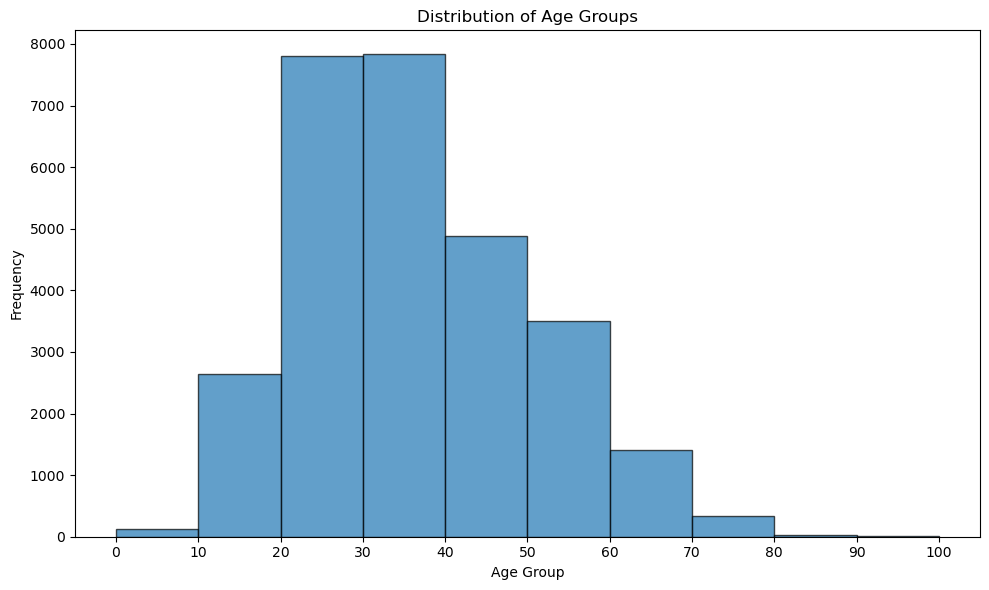

{25: 28.536440292502014, 35: 26.39865645008922, 45: 16.63692662957909, 55: 11.542633217872012, 15: 10.986319582939716, 65: 4.377033693712606, 75: 0.9376858752317974, 5: 0.47933942129386653, 85: 0.087470697316399, 95: 0.0174941394632798}


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group
10419,59898,santa ana,california,"usa""",1.0,5
375,2152,grosse pointe,michigan,"usa""",1.0,5
41552,240214,harrodsburg,kentucky,"usa""",1.0,5
36826,213096,los angeles,california,"usa""",1.0,5
43921,253090,gatineau,quebec,"canada""",1.0,5
...,...,...,...,...,...,...
39011,225867,despair,indiana,"usa""",93.0,95
41730,241131,l.a.,california,"usa""",94.0,95
24739,142329,am sueden,n/a,"luxembourg""",96.0,95
19838,114865,croydon,victoria,"australia""",97.0,95


In [42]:
users_df_copy = pd.read_csv("BX-Users.csv")
users_df_copy.dropna(subset=["User-Age"], inplace=True)

users_df_copy["User-Age"] = pd.to_numeric(users_df_copy["User-Age"], errors="coerce")
users_df_copy.dropna(subset=["User-Age"], inplace=True)
users_df_copy = users_df_copy.loc[users_df_copy["User-Age"] < 100]
users_df_copy = users_df_copy.loc[users_df_copy["User-Age"] > 0]

# Define the bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Define the labels for each bin
labels = [
    5,
    15,
    25,
    35,
    45,
    55,
    65,
    75,
    85,
    95,
]

# Discretize the data
users_df_copy["Age-Group"] = pd.cut(users_df_copy["User-Age"], bins=bins, labels=labels)
users_df_copy = users_df_copy.sort_values(by="User-Age", ascending=True)

# Make a histogram to show the distribution of age groups
plt.figure(figsize=(10, 6))
plt.hist(users_df_copy["User-Age"], bins=bins, edgecolor="black", alpha=0.7)

# Set xticks at the center of each bin
plt.xticks(bins, bins)

plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Count the number of each age group
age_group_counts = users_df_copy["Age-Group"].value_counts()

# Calculate the age-group percentage
age_group_percentages = (age_group_counts / len(users_df_copy)) * 100
age_group_percentages_dict = age_group_percentages.to_dict()
print(age_group_percentages_dict)

users_df_copy

In [43]:
random_filled_ages = list(age_group_percentages_dict.keys())
total_percentage = sum(age_group_percentages_dict.values())
weights = [v / total_percentage for v in age_group_percentages_dict.values()]

In [44]:
users_df = pd.read_csv('BX-Users.csv')
rating_df = pd.read_csv("BX-Ratings.csv")
books_df = pd.read_csv('BX-Books.csv')

# Remove non-digit characters from 'User-Age' column
users_df["User-Age"] = users_df["User-Age"].str.replace(r"\D", "", regex=True)

# Convert 'User-Age' column to numeric
users_df["User-Age"] = pd.to_numeric(users_df["User-Age"], errors="coerce")

# Count the rows where user age is null
count_null_age = users_df["User-Age"].isnull().sum()

# Count the rows where user age is less than 10 and greater than 99
count_extreme_ages = ((users_df["User-Age"] < 10) | (users_df["User-Age"] > 99)).sum()

# Total number of rows with errored age or null
error_age_count = count_null_age + count_extreme_ages

# Generate a list of random numbers between 10 and 99
random.seed(42)
random_ages = []
for i in range(error_age_count):
    random_ages.append(np.random.choice(random_filled_ages, p=weights))
print(random_ages)

# Create a mask for rows where user age is null or falls outside the range [10, 99]
error_age_rows = (
    users_df["User-Age"].isnull()
    | (users_df["User-Age"] < 10)
    | (users_df["User-Age"] > 99)
)

# Extract the indexes of the rows that satisfy the condition
error_age_indexes = users_df.index[error_age_rows].tolist()

fill_age = {idx:ages for idx,ages in zip(error_age_indexes, random_ages)}

# Iterate over the fill_age dictionary and update the DataFrame
for idx, age in fill_age.items():
    users_df.loc[idx, "User-Age"] = age

[35, 15, 25, 25, 35, 35, 55, 35, 25, 35, 45, 45, 25, 35, 25, 15, 45, 25, 45, 35, 15, 45, 35, 15, 45, 25, 35, 35, 35, 25, 25, 45, 45, 45, 25, 45, 35, 25, 15, 25, 45, 45, 45, 25, 25, 25, 55, 25, 25, 55, 15, 35, 35, 45, 25, 25, 25, 55, 15, 35, 25, 15, 45, 45, 35, 45, 25, 15, 55, 45, 25, 25, 15, 25, 35, 25, 65, 25, 55, 65, 25, 45, 65, 35, 35, 35, 25, 45, 35, 55, 35, 25, 35, 25, 55, 35, 25, 35, 55, 35, 25, 25, 35, 25, 15, 15, 25, 25, 35, 25, 55, 25, 45, 15, 55, 25, 25, 15, 15, 45, 45, 25, 25, 15, 55, 25, 15, 25, 35, 15, 45, 55, 15, 55, 25, 25, 35, 65, 25, 45, 35, 45, 35, 65, 45, 55, 45, 35, 55, 65, 15, 25, 55, 25, 35, 35, 25, 55, 15, 25, 25, 35, 35, 25, 65, 45, 35, 35, 35, 25, 25, 55, 35, 35, 65, 35, 15, 35, 15, 35, 25, 25, 25, 25, 25, 35, 45, 75, 45, 45, 45, 25, 45, 55, 55, 35, 35, 55, 45, 55, 45, 15, 35, 25, 15, 25, 45, 35, 25, 25, 35, 35, 15, 45, 35, 45, 25, 35, 35, 75, 65, 25, 55, 45, 25, 35, 35, 25, 35, 15, 45, 15, 25, 25, 25, 55, 55, 15, 25, 55, 15, 15, 35, 65, 25, 25, 45, 45, 25, 15,

Fill missing data of User-Country with `random` as well.

In [45]:
# List all the countries in the data
country_list = list(users_df["User-Country"].dropna().unique())

# List row indexes where User-Country is null
nan_indexes = list(users_df["User-Country"][users_df["User-Country"].isnull()].index)

# Count total number of rows with null
count_nan = len(nan_indexes)

# Generate random countries for all null rows
random.seed(42)
random_countries = [random.choice(country_list) for _ in range(count_nan)]

fill_country = {idx:countries for idx,countries in zip(nan_indexes, random_countries)}

# Fill gaps in User-Country column
users_df["User-Country"] = users_df["User-Country"].fillna(fill_country)
users_df

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",35.0
1,9,germantown,tennessee,"usa""",15.0
2,16,albuquerque,new mexico,"usa""",25.0
3,17,chesapeake,virginia,"usa""",25.0
4,19,weston,,"barbados""",14.0
...,...,...,...,...,...
48294,278846,toronto,ontario,"canada""",23.0
48295,278849,georgetown,ontario,"canada""",23.0
48296,278851,dallas,texas,"usa""",33.0
48297,278852,brisbane,queensland,"australia""",32.0


Similarly, fill missing data of User-City in `random`.

In [46]:
# List all the cities in the data
city_list = list(users_df["User-City"].dropna().unique())

# List row indexes where User-City is null
nan_indexes = list(users_df["User-City"][users_df["User-City"].isnull()].index)

# Count total number of rows with null
count_nan = len(nan_indexes)

# Generate random cities for all null rows
random.seed(42)
random_cities = [random.choice(city_list) for _ in range(count_nan)]

fill_city = {idx:cities for idx,cities in zip(nan_indexes, random_cities)}

# Fill gaps in User-City column
users_df["User-City"] = users_df["User-City"].fillna(fill_city)
users_df

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",35.0
1,9,germantown,tennessee,"usa""",15.0
2,16,albuquerque,new mexico,"usa""",25.0
3,17,chesapeake,virginia,"usa""",25.0
4,19,weston,,"barbados""",14.0
...,...,...,...,...,...
48294,278846,toronto,ontario,"canada""",23.0
48295,278849,georgetown,ontario,"canada""",23.0
48296,278851,dallas,texas,"usa""",33.0
48297,278852,brisbane,queensland,"australia""",32.0


Check the distribution of raw data, draft below

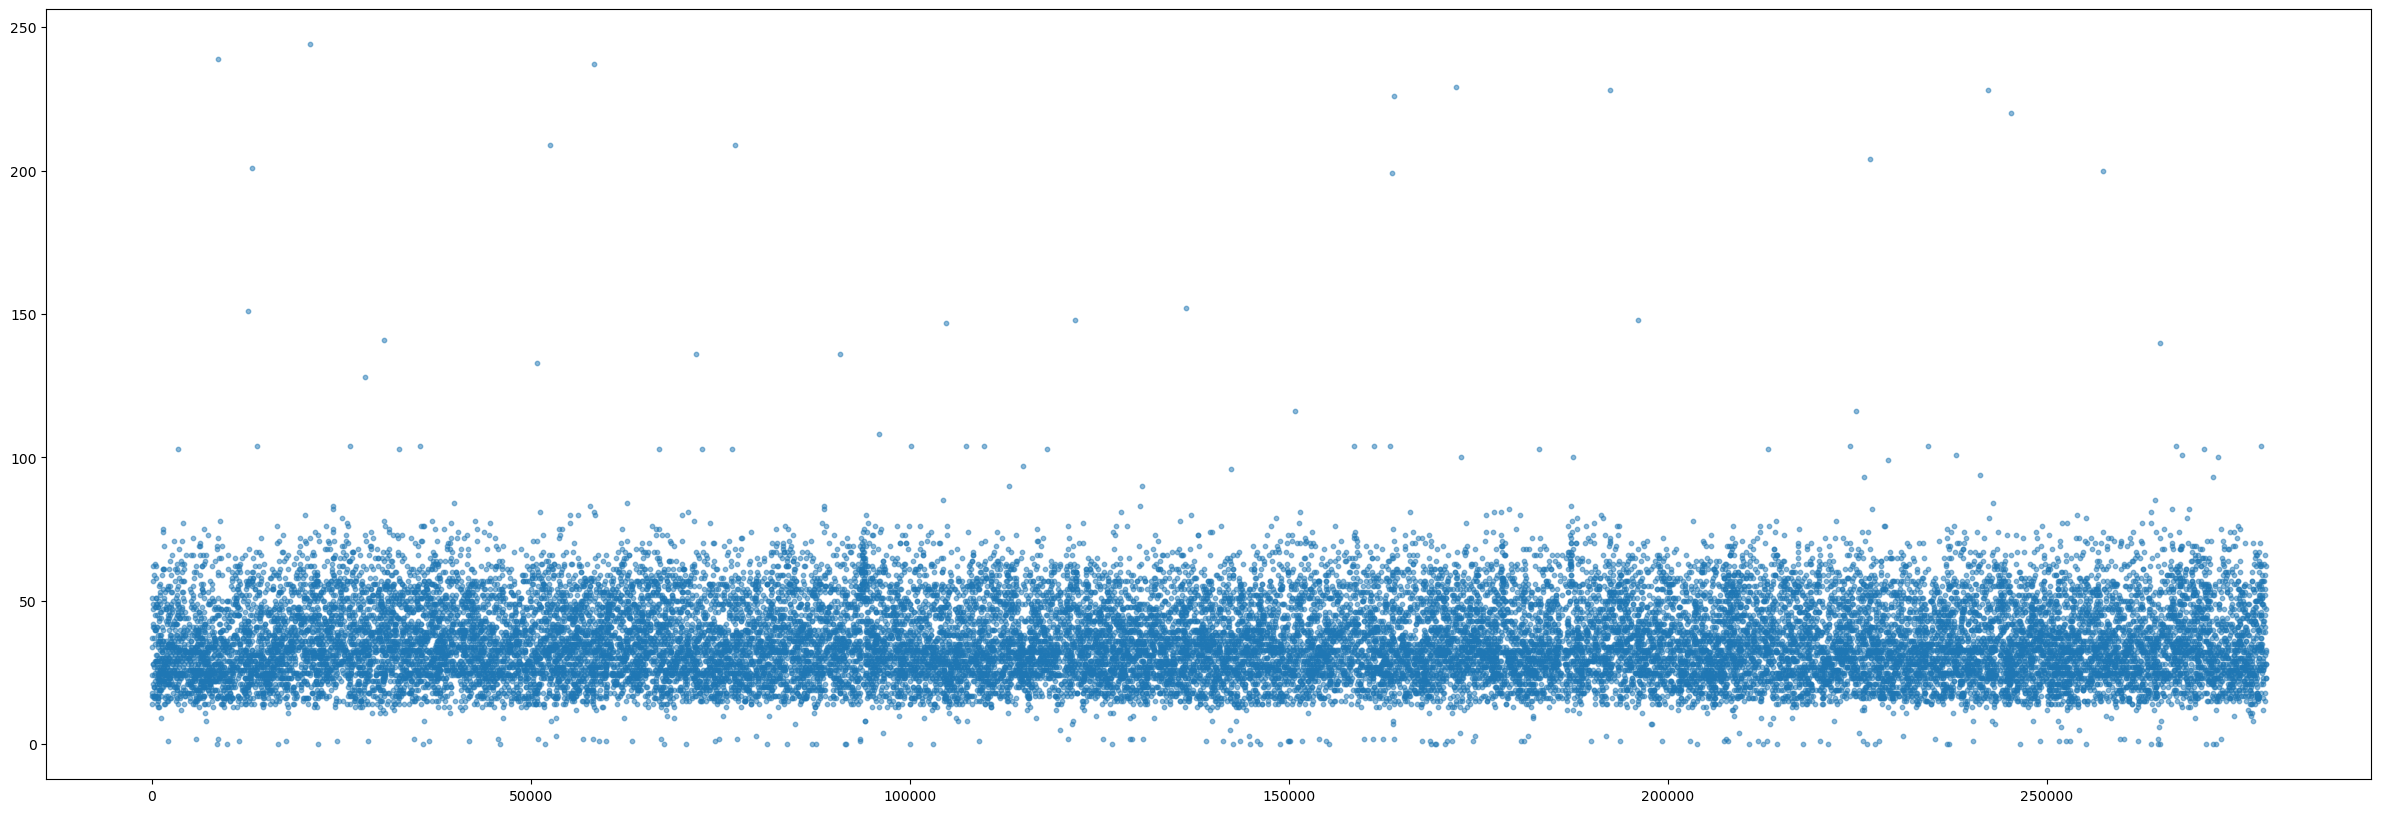

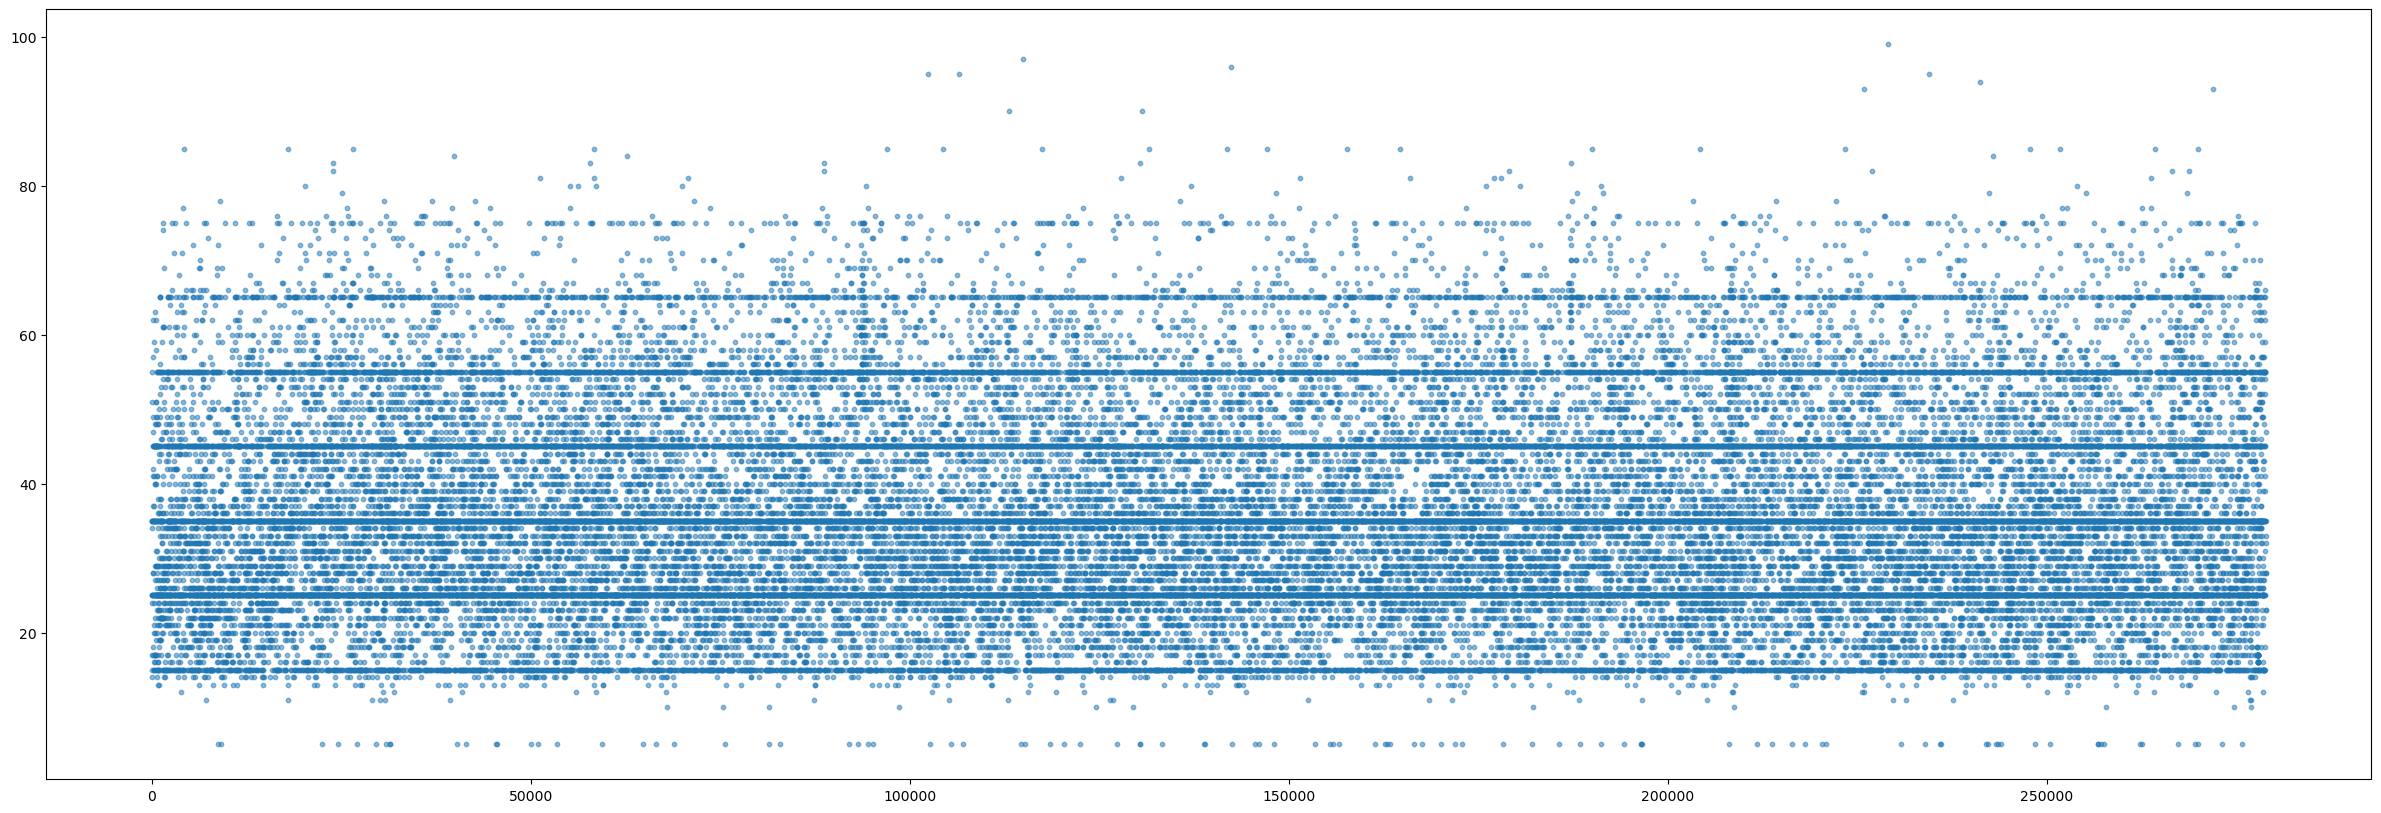

In [47]:
books_cp = pd.read_csv("BX-Users.csv")

# Remove non-digit characters from 'User-Age' column
books_cp["User-Age"] = books_cp["User-Age"].str.replace(r"\D", "", regex=True)

# Convert 'User-Age' column to numeric
books_cp["User-Age"] = pd.to_numeric(books_cp["User-Age"], errors="coerce")

plt.figure(figsize=(30, 10))
plt.scatter(x=books_cp["User-ID"], y=books_cp["User-Age"], s=10, alpha=0.5)
plt.show()

plt.figure(figsize=(30, 10))
plt.scatter(x=users_df["User-ID"], y=users_df["User-Age"], s=10, alpha=0.5)
plt.show()

## Discretising below

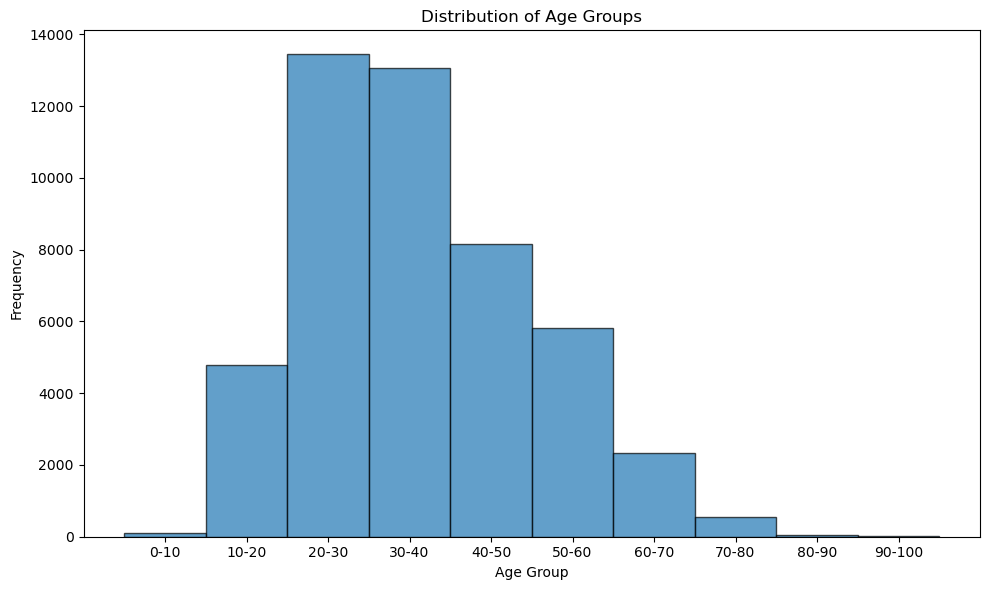

,User-ID,User-City,User-State,User-Country,User-Age,Age-Group
0,8,timmins,ontario,"canada""",35.0,30-40
1,9,germantown,tennessee,"usa""",15.0,10-20
2,16,albuquerque,new mexico,"usa""",25.0,20-30
3,17,chesapeake,virginia,"usa""",25.0,20-30
4,19,weston,,"barbados""",14.0,10-20
...,...,...,...,...,...,...
48294,278846,toronto,ontario,"canada""",23.0,20-30
48295,278849,georgetown,ontario,"canada""",23.0,20-30
48296,278851,dallas,texas,"usa""",33.0,30-40
48297,278852,brisbane,queensland,"australia""",32.0,30-40


In [48]:
 # Define the bins of
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# lable all the bins
labels = [
    "0-10",
    "10-20",
    "20-30",
    "30-40",
    "40-50",
    "50-60",
    "60-70",
    "70-80",
    "80-90",
    "90-100",
]

# Discretise the data
users_df["Age-Group"] = pd.cut(users_df["User-Age"], bins=bins, labels=labels)
# users_df = users_df.sort_values(by="User-Age", ascending=True)

# Make a histogram to show the distribution of all discretised data
plt.figure(figsize=(10, 6))
plt.hist(users_df["User-Age"], bins=bins, edgecolor="black", alpha=0.7)

# Set xticks at the center of each bin
plt.xticks([5, 15, 25, 35, 45, 55, 65, 75, 85, 95], labels) 

plt.title("Distribution of Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Frequency") 
plt.tight_layout()
plt.show()


users_df

Connect Users and Their ratings together, draw a scatter plot to analyse the distribution of age vs rating

In [49]:
merged_df = pd.merge(users_df, rating_df, on="User-ID", how="inner")
merged_df = pd.merge(merged_df, books_df, on="ISBN", how="inner")
print(merged_df.isnull().sum())


merged_df

User-ID                0
User-City              0
User-State             0
User-Country           0
User-Age               0
Age-Group              0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64


,User-ID,User-City,User-State,User-Country,User-Age,Age-Group,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
0,8,timmins,ontario,"canada""",35.0,30-40,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,11676,bar harbor,n/a,"n/a""",45.0,40-50,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,67544,toronto,ontario,"canada""",30.0,20-30,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,123629,kingston,ontario,"canada""",35.0,30-40,0002005018,9,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
4,200273,comber,ontario,"canada""",25.0,20-30,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
...,...,...,...,...,...,...,...,...,...,...,...,...
204159,265784,san jose,california,"usa""",35.0,30-40,0886775809,7,"The Law of Becoming (Jaran, Book 4)",Kate Elliott,1994,Daw Books
204160,246196,euclid,ohio,"usa""",24.0,20-30,0375700110,4,Half and Half: Writers on Growing Up Biracial ...,Claudine C. O'Hearn,1998,Pantheon Books
204161,257485,santa clara,california,"usa""",24.0,20-30,0375700110,6,Half and Half: Writers on Growing Up Biracial ...,Claudine C. O'Hearn,1998,Pantheon Books
204162,274666,ypsilanti,michigan,"usa""",35.0,30-40,0375700110,9,Half and Half: Writers on Growing Up Biracial ...,Claudine C. O'Hearn,1998,Pantheon Books


In [50]:
"""
Malory put ur work in this box pls!
"""

'\nMalory put ur work in this box pls!\n'

In [51]:
def compute_probability(col):
    """
    Compute the probability of a certain event
    """
    return col.value_counts() / col.shape[0]


def compute_entropy(col):
    """
    Compute the entropy of a certain event
    """
    probabilities = compute_probability(col)
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy


def compute_conditional_entropy(x, y):
    """
    Compute the conditional entropy between two random variables.
    Specifically, the conditional entropy of Y given X.
    """
    probability_x = compute_probability(x)

    temp_df = pd.DataFrame({"X": x, "Y": y})

    conditional_entropy = 0

    # for unique event x_i
    for x_i in x.unique():
        # get the data for Y given X=x_i
        y_given_x = temp_df.loc[temp_df["X"] == x_i, "Y"]

        # compute the conditional entropy
        conditional_entropy += probability_x[x_i] * compute_entropy(y_given_x)

    return conditional_entropy


def compute_information_gain(x, y):
    """
    Compute the information gain between an attribute and class label
    """
    return compute_entropy(y) - compute_conditional_entropy(x, y)

In [52]:
# for feature in ['User-City', 'User-State' ,	'User-Country', 'Age-Group', 'Book-Author', 'Year-Of-Publication', 'Book-Publisher']:
#     print(feature, compute_information_gain(merged_df[feature], merged_df["Book-Rating"]).round(4))